# Cross Validation

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (8, 5)
%config InlineBackend.figure_format = 'retina'

# Diabetes dataset

In [2]:
# Meseares of various features and diabetes disease progression for 442 patients.
# Available at https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt
df = pd.read_csv('diabetes.csv')
df

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,DIS
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


In [3]:
features = list(df.columns.values)
features.remove('DIS')
features

['AGE', 'SEX', 'BMI', 'BP', 'TC', 'LDL', 'HDL', 'TCH', 'LTG', 'GLU']

# Standardized data

In [4]:
X = df.loc[:,'AGE':'GLU'].to_numpy()
y = df['DIS'].to_numpy()

featureMeans = X.mean(axis=0)
featureStd = X.std(axis=0)

Xs = (X - featureMeans) / featureStd

disMean = y.mean()
disStd = y.std()

ys = (y - disMean) / disStd

# Let's perform Ridge regression

# Error to be minimized $= SSE + \alpha \sum_j \beta_j^2$

In [5]:
from sklearn.linear_model import Ridge

# Step #1: Find optimal value of $\alpha$

# Split data into training (50%) and testing (50%) groups

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# exact way data are split is determined by random_state
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle=True, test_size=0.5, random_state=1)
alphas = np.logspace(-5, 2, 50)
mse = np.zeros(alphas.shape)
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(Xs_train, ys_train)
    residuals = ys_test - model.predict(Xs_test)
    mse[i] = np.sum(residuals**2) / len(residuals)

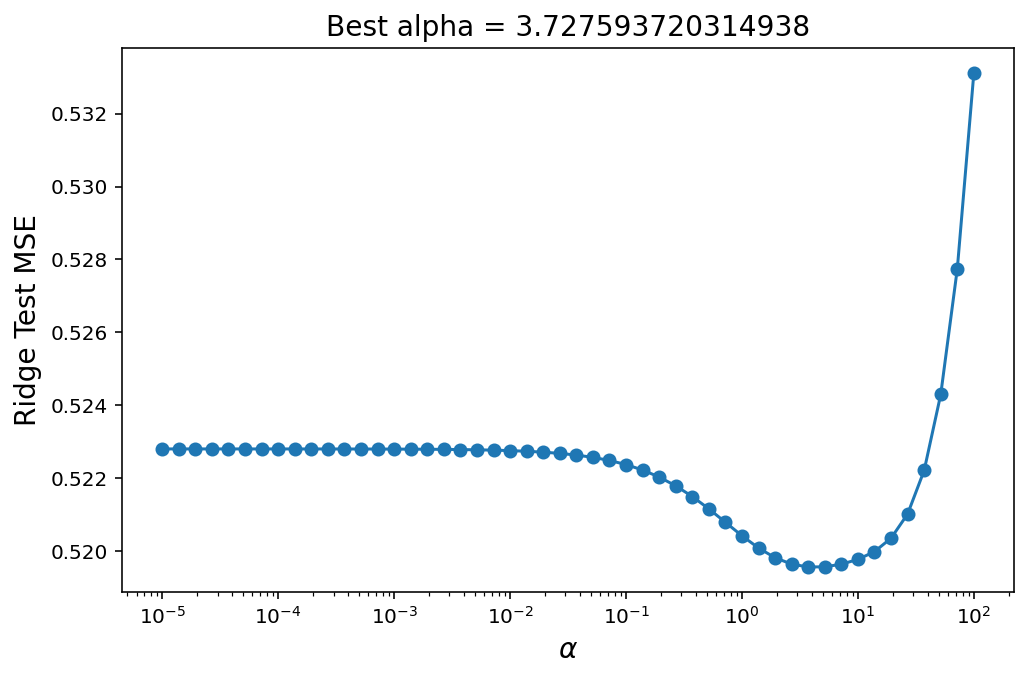

In [8]:
ind = np.argmin(mse)
alpha = alphas[ind]
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge Test MSE')
plt.title(f"Best alpha = {alpha}");

# Split data into different training (50%) and testing (50%) groups

In [9]:
# exact way data are split is determined by random_state
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle=True, test_size=0.5, random_state=2)
alphas = np.logspace(-5, 2, 50)
mse = np.zeros(alphas.shape)
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(Xs_train, ys_train)
    residuals = ys_test - model.predict(Xs_test)
    mse[i] = np.sum(residuals**2) / len(residuals)

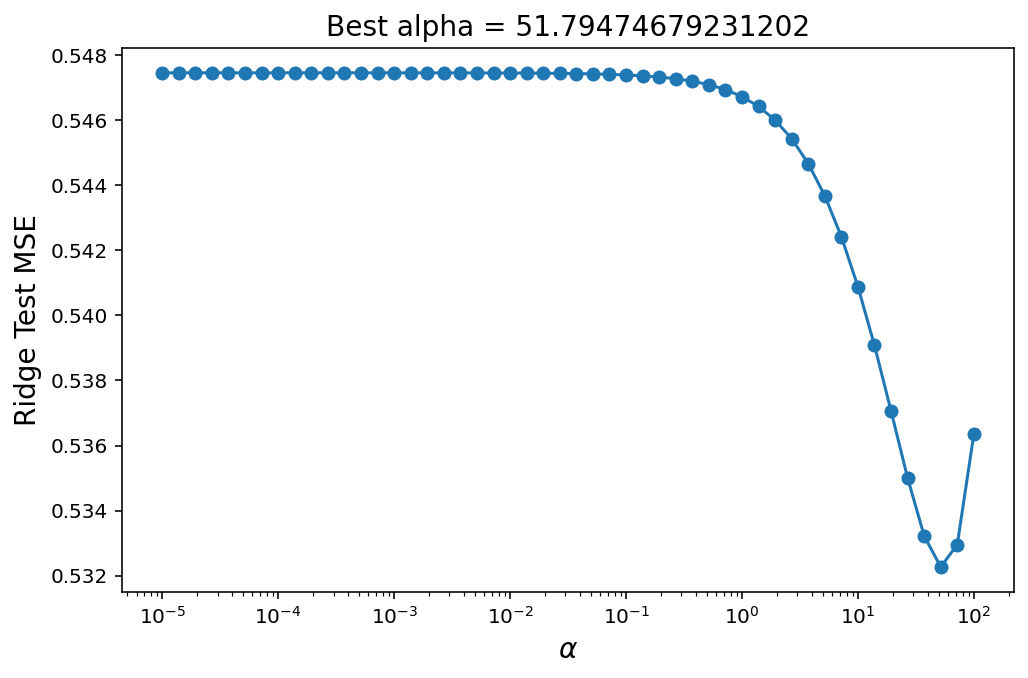

In [10]:
ind = np.argmin(mse)
alpha = alphas[ind]
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge Test MSE')
plt.title(f"Best alpha = {alpha}");

# Which way of splitting the data should we use?

## <font color=red>There is no single a priori *correct* way to split the data.</font>

## Trends in the data due to noncontrolled variables, random experimental artifacts, and outliers can all impact our model results based on how they are dstributed between training and testing groups.

## To mitigate such effects, we can use cross validation to split the data in multiple ways and obtain an average score across each of the various splits.

# Let's determine $\alpha$ using K-fold cross validation

In [11]:
from sklearn.model_selection import KFold

# Visualizing how the data is split for 3-fold cross validation

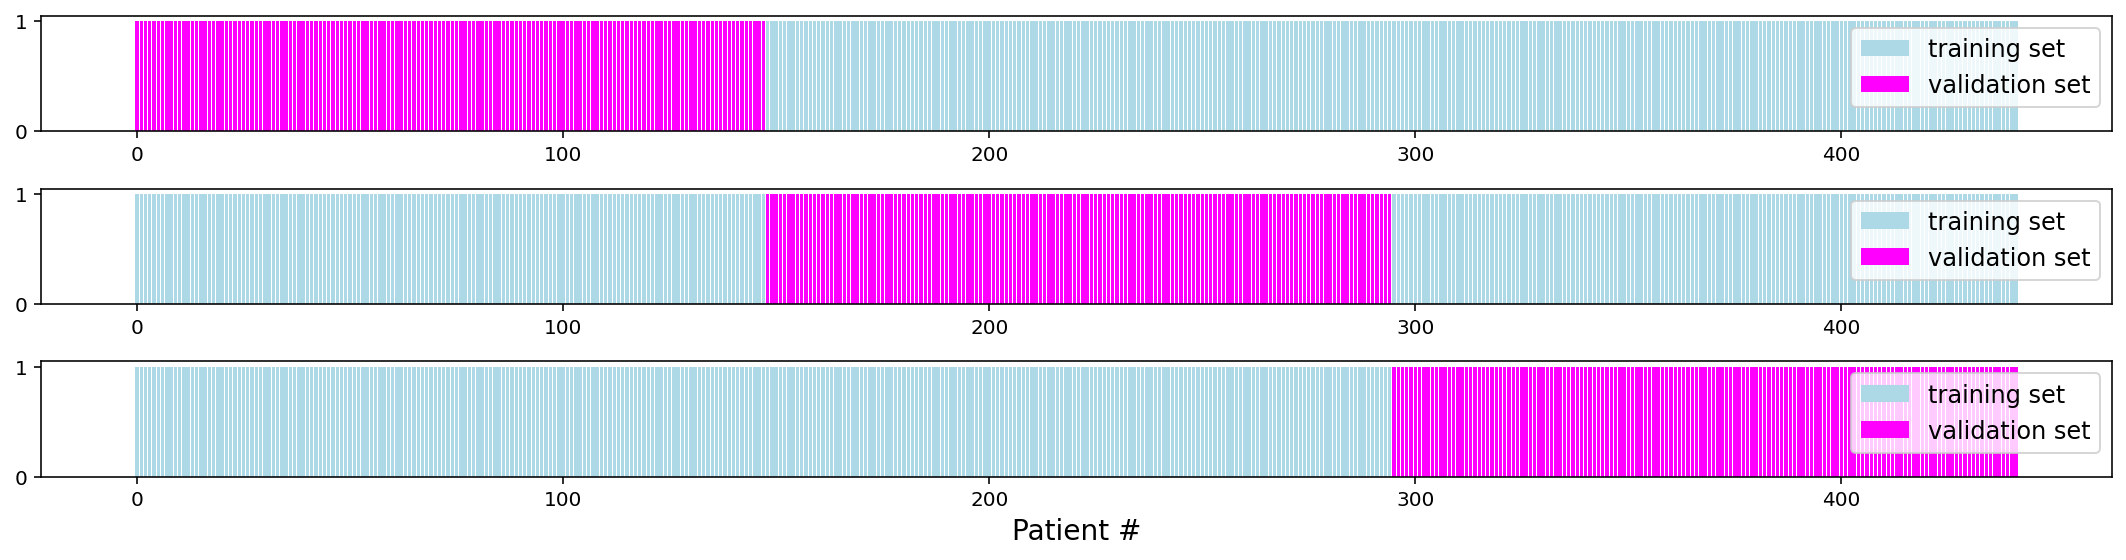

In [12]:
kf = KFold(n_splits=3, shuffle=False)

plt.figure(figsize=(15,4))
k = 1
for train_index, val_index in kf.split(Xs, ys):
    plt.subplot(3, 1, k)
    plt.bar(train_index, np.ones(train_index.shape), color='lightblue', label='training set')
    plt.bar(val_index, np.ones(val_index.shape), color='magenta', label='validation set')
    plt.legend()
    k += 1
plt.xlabel('Patient #')
plt.tight_layout()

# Visualizing how the data is split for 3-fold cross validation (with shuffling!)

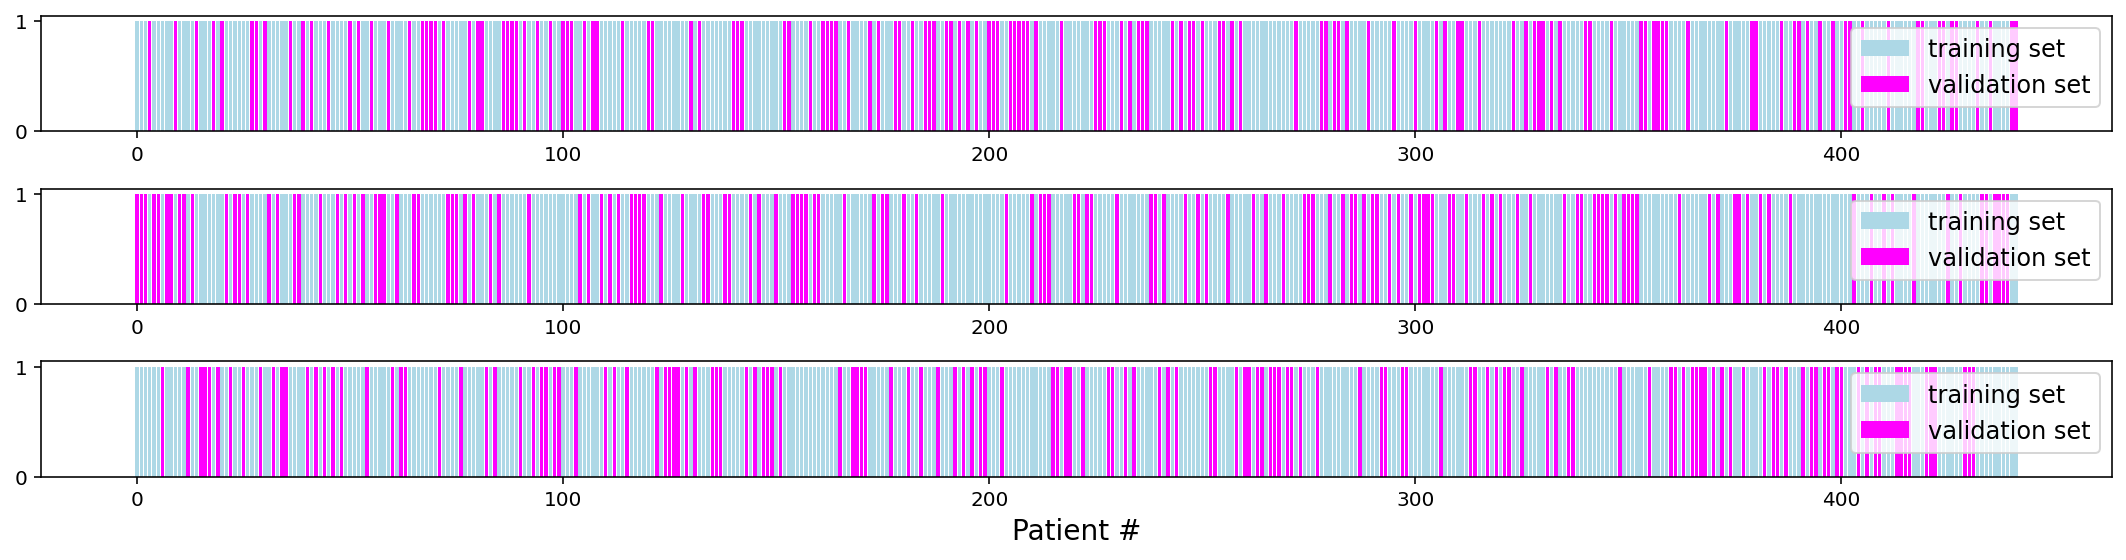

In [13]:
kf = KFold(n_splits=3, shuffle=True)

plt.figure(figsize=(15,4))
k = 1
for train_index, val_index in kf.split(Xs, ys):
    plt.subplot(3, 1, k)
    plt.bar(train_index, np.ones(train_index.shape), color='lightblue', label='training set')
    plt.bar(val_index, np.ones(val_index.shape), color='magenta', label='validation set')
    plt.legend()
    k += 1
plt.xlabel('Patient #')
plt.tight_layout()

# Perform K-fold cross validation for a bunch of $\alpha$ and use the average validation MSE to pick the optimal $\alpha$

In [14]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

alphas = np.logspace(-5, 2, 50)
mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    val_errors = []
    for train_index, val_index in kf.split(Xs, ys):
        # training set
        Xs_train = Xs[train_index,:]
        ys_train = ys[train_index]
        
        # validation set
        Xs_val = Xs[val_index,:]
        ys_val = ys[val_index]
        
        # ridge model
        model = Ridge(alpha=alpha)
        
        # fit model to training set
        model.fit(Xs_train, ys_train)
        
        # get error from validation set
        val_mse = np.mean((ys_val - model.predict(Xs_val))**2)
        val_errors.append(val_mse)
    
    # for each alpha, we take the mean error across all K-folds
    mse[i] = np.mean(val_errors)

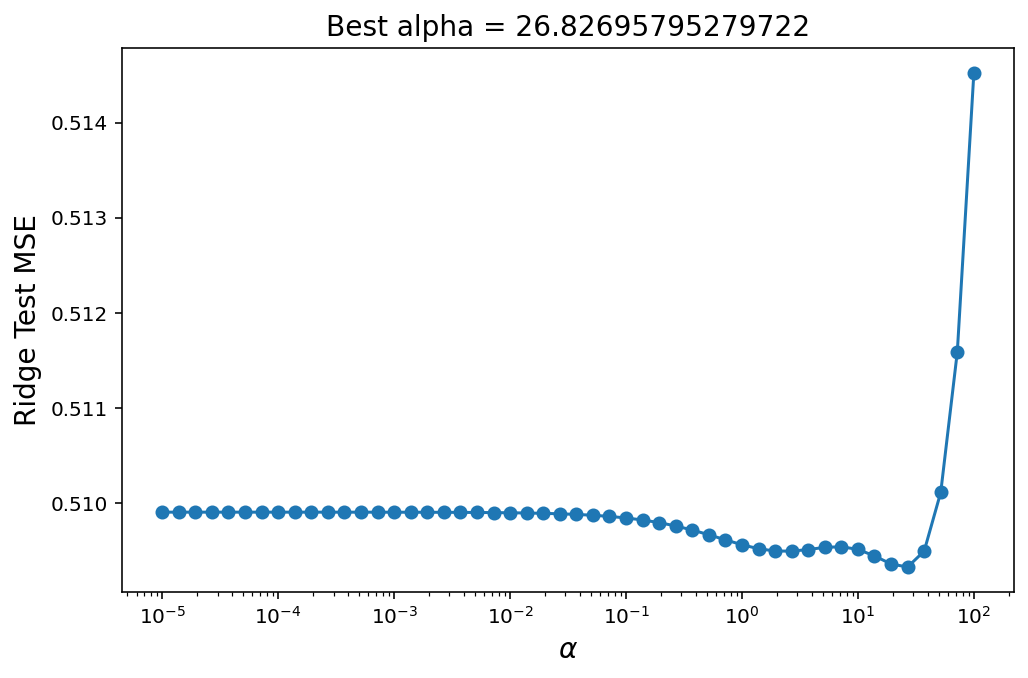

In [15]:
ind = np.argmin(mse)
alpha = alphas[ind]
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge Test MSE')
plt.title(f"Best alpha = {alpha}");

# K-fold cross validation wrapped up nice and neat for you

In [16]:
from sklearn.model_selection import cross_validate

alphas = np.logspace(-5, 2, 50)
mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    results = cross_validate(model, Xs, ys, cv=10, scoring='neg_mean_squared_error')
    mse[i] = -results['test_score'].mean()

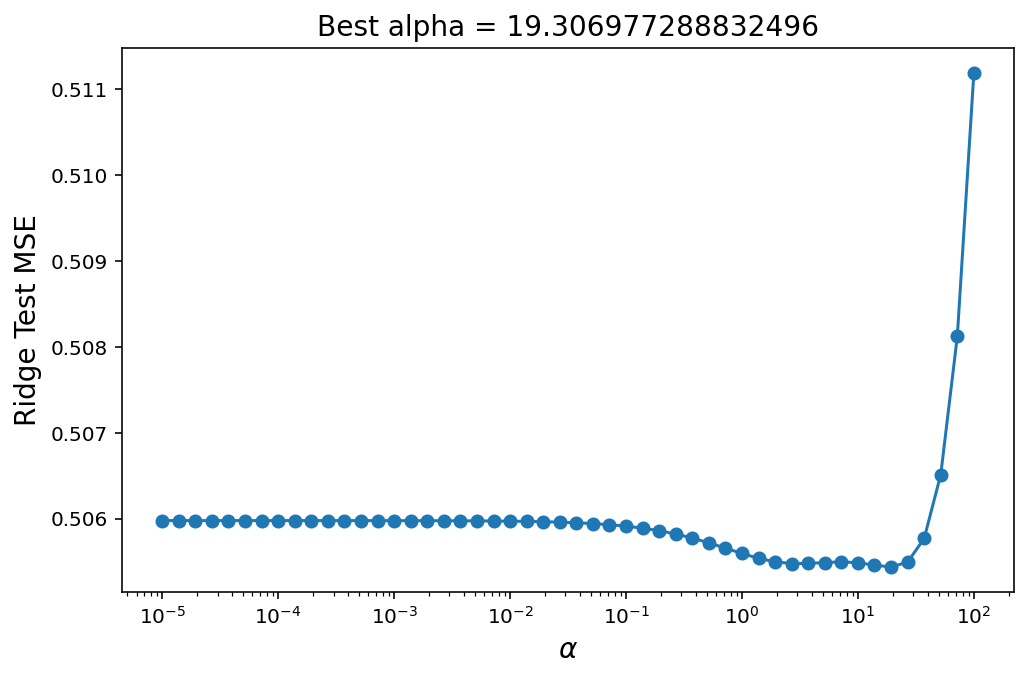

In [17]:
ind = np.argmin(mse)
alpha = alphas[ind]
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge Test MSE')
plt.title(f"Best alpha = {alpha}");

# Exhaustive grid search over parameter space

In [18]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': np.logspace(-5, 2, 50)}
model = Ridge()
cvmodel = GridSearchCV(model, params, cv=10, scoring='neg_mean_squared_error')
cvmodel.fit(Xs, ys)
alpha = cvmodel.best_params_['alpha']
alpha

19.306977288832496

# Non-exhaustive randomized search across parameter space (much faster when parameter space is huge)

In [19]:
from sklearn.model_selection import RandomizedSearchCV

params = {'alpha': np.logspace(-5, 2, 50)}
model = Ridge()
cvmodel = RandomizedSearchCV(model, params, cv=10, scoring='neg_mean_squared_error')
cvmodel.fit(Xs, ys)
alpha = cvmodel.best_params_['alpha']
alpha

19.306977288832496

# What if we want to compare our Ridge model to some other model?

In [20]:
model = Ridge(alpha=alpha)
model.fit(Xs, ys)
mse = np.mean((ys - model.predict(Xs))**2)
mse

0.48532054564378146

## What's wrong with using this MSE as a comparitor?

## What about this MSE?

In [21]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle=True, test_size=0.5, random_state=2)
model = Ridge(alpha=alpha)
model.fit(Xs_train, ys_train)
mse = np.mean((ys_test - model.predict(Xs_test))**2)
mse

0.5370629998437009

# Learning the parameters of a prediction function and testing it on the same data is a methodological mistake

![](images/cv_data_split.png)

## Step 1: Split data into training and testing groups

## Step 2: Determine model hyperparameters (e.g. $\alpha$) using cross validation on the training set

## Step 3: Determine model parameters (e.g. $\beta$) by fitting model with chosen hyperparameters (e.g. $\alpha$) to entire training set

## Step 4: Evaluate model performance as the error with respect to the testing set (data that was never used during training at any point)

# <font color=darkred>Exercise</font>

1. Fit the diabetes dataset with a Ridge model using 5-fold cross validation to determine the optimal value of $\alpha$.
2. Report a mean squared error that can be used as a comparitor with other models.
3. Do the same for a Lasso model.
4. Which model is best?

# Leave One Out cross validation

![](images/loo.png)

In [22]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

alphas = np.logspace(-5, 2, 50)
mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    val_errors = []
    for train_index, val_index in loo.split(Xs, ys):
        # training set
        Xs_train = Xs[train_index,:]
        ys_train = ys[train_index]
        
        # validation set
        Xs_val = Xs[val_index,:]
        ys_val = ys[val_index]
        
        # ridge model
        model = Ridge(alpha=alpha)
        
        # fit model to training set
        model.fit(Xs_train, ys_train)
        
        # get error from validation set
        val_mse = np.mean((ys_val - model.predict(Xs_val))**2)
        val_errors.append(val_mse)
    
    # for each alpha, we take the mean error across all K-folds
    mse[i] = np.mean(val_errors)

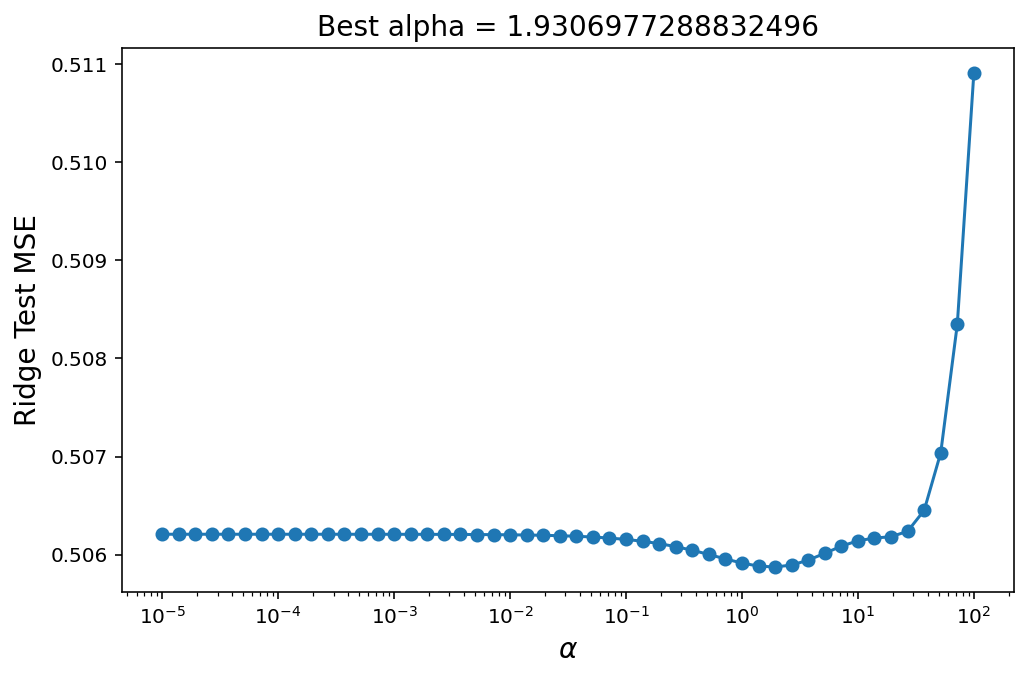

In [23]:
ind = np.argmin(mse)
alpha = alphas[ind]
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge Test MSE')
plt.title(f"Best alpha = {alpha}");